In [1]:
#Import libraries 

import numpy as np
import numpy.random as rd
import random
import pandas as pd
from scipy.sparse import dia_matrix, identity
from scipy.sparse.linalg import inv, spsolve
import scipy
import statsmodels.api as sm
from scipy.stats import truncnorm,norm
import statistics as stat
from scipy.stats import chi2
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
plt.rcParams["font.family"] = "Times New Roman"

#Change Graphics (optional)
from IPython.core.display import display, HTML
display(HTML("<style>.container{width: 100% !important; }< / style>"))
import importlib

#Import Original Libraries
import TrendFiltering_v2_public as tf

#Use custom harmonic mean( to avoid zero division)
from scipy import stats
hm_offset = 0.0001
def hmean(values_list):
    if values_list[0] is None and\
       values_list == [values_list[0]] * len(values_list):
        return None
    if max(values_list) <= 0:
        return 0
    return stats.hmean(
        [v if v > 0 else hm_offset for v in values_list if v is not None])

# Create syntetic data
The below cell creates syntetic 1-D time series mimicing displacements of GNSS stations along the plate motion
- Requirement:
    - $n$: length of time series [day]
    - $v_0$: stationary displacement along the plate motion [cm/day]
    - $interval$: interval of SSE occurrence [day]
    - $duration$: duration of SSE [day]
    - $changepointstartday$: days at which SSE starts 
    - $noisesd$: noise level at each station
- Output: time series at station $s$
$$X[s][t]=v_0\times t-\sum_i v_1[s]\times(1-\exp(-(t-changepointstartday[i])/duration))1_{t>changepointstartday[i]}+sd\times whitenoise$$

In [2]:
#Create synthetic data#

##Set-up##
n  = 365*2 # [day]
v0 = 2 / (365) #[cm/day]
interval = 30 # [day]
changepoint_startday = np.array([interval*(t+1) for t in range(n//interval -1)])
duration = 5 # [day]
changepoint_endday   = changepoint_startday+duration
noise_sd = [0.05, 0.07, 0.1, 0.04, 0.04, 0.05 , 0.06  ] # noise at each station[cm]
v1 = [ 0.15, 0.15, 0.15, 0.15, 0.15, 0.15 , 0.15] # slip at each station [cm]

##Create stationary displacement##
theta = []
for s in range(6):
    theta.append(np.array([ 0 + v0*i for i in range(n)])) # true stationary displacement [cm]

##Create true displacement: Add slip to stationary displacement##
count = 0
for s in range(6):
    for i in range(len(changepoint_startday)):
        offset=[-v1[s]*(1-np.exp(-(1/duration)*(t-changepoint_startday[i])))  if ((t > changepoint_startday[i])) else 0  for t in range(n) ]
        theta[count] = theta[count] + offset
    count += 1
    
##Create observation at each station: Add noise to true displacement##
X = []
for s in range(6):
    X.append(theta[s]+rd.normal(0,noise_sd[s],n))

# Apply l1 trend filtering

The below cells apply l1 trend filtering to 1-D time series

- l1 trend filtering: l1 trend filtering is the fitting of piecewise linear time series without using the prior knowledge about knots (kink points)
- Input: X, k, param_regularization, param_Lagrange

    - X: 1-dim sequence

    - k: fitting piecewise (k-1)-polynomial

    - param_regularization: a value of regularization hyperparameter (if you would like to select it, please check the 2nd output (Cp value) discussed below)

    - param_Lagrange: a value of optimization hyperparameter (no need to optimize; default value is 1)
    
- Output: list consisting of (fitting result, Cp value, 2nd order difference of fitting result)
    - fitting result: fitting result
    - Cp value: criterion for selecting the regularization hyperparameter (smaller is preferable)
    - 2nd order difference of fitting result: check that this is a sparse vector

# Removing outliers 
If the time series contains outliners, outlier removal would be required.

The below cell provides a program of removing outliers that replace values of which residual (relative to the spline) larger than thredhold*(sd)
$$estimatesd= \sqrt{\sum_t(input[t]-spline[t])^2 / length}$$
If $|input[t]-spline[t]|<threhold\times estimatesd$ then $output[t] = input[t]$; else $output[t] = spline[t]$.
- Requirement: 1-D time series, threshold (default ==2.)
- Output: time series without outliners

In [11]:
#Apply the outlier elimination
X_or=tf.outlierremove(X[5],threshold=2.)

In [12]:
#Apply l1 trend filtering
tf_result=tf.trend_filtering(X_or,k=2,param_regularization=0.3,param_Lagrange=1)

In [19]:
interval_ticks

0.144

Text(0, 0.5, 'Displacement')

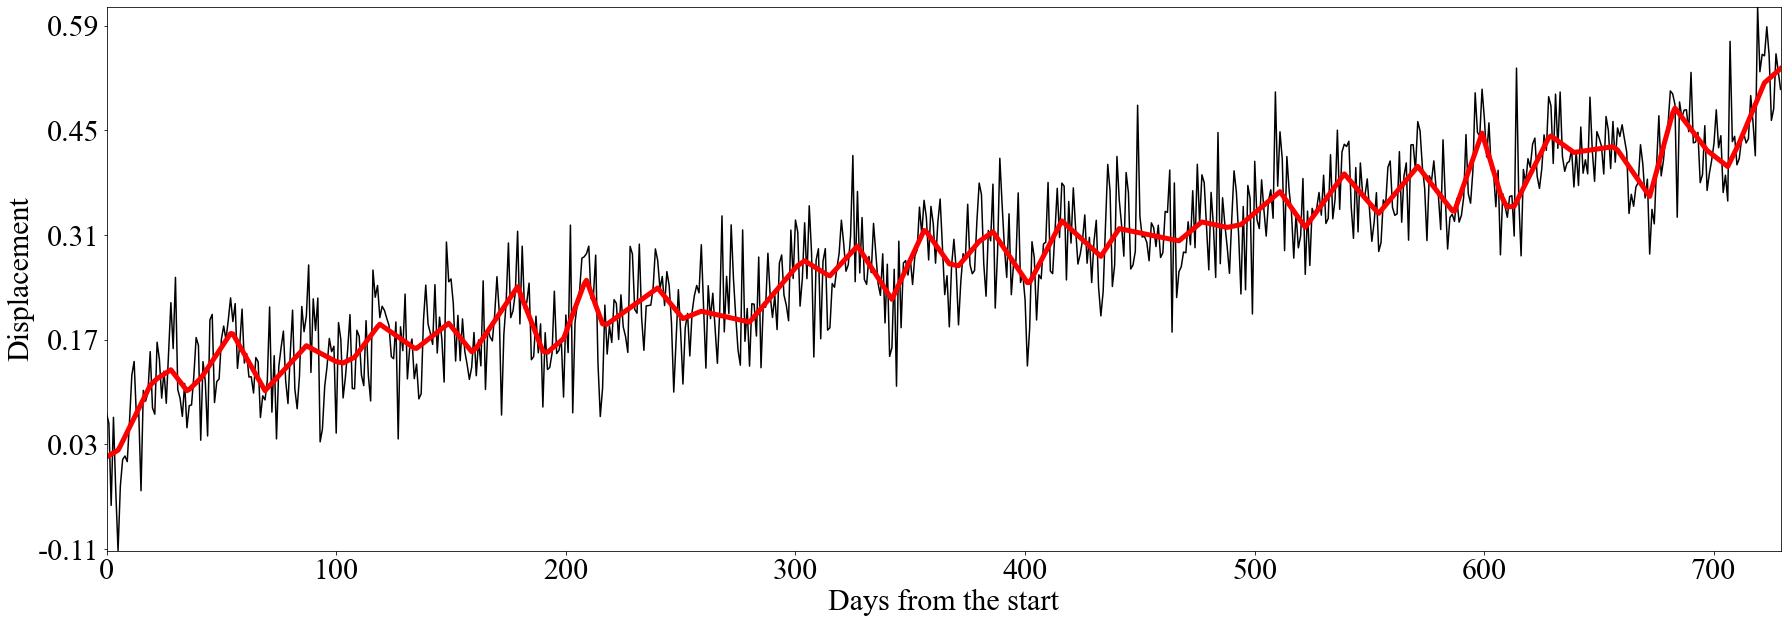

In [25]:
##Display fitting result##
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
ax.plot(X[5],color="black")
y_min = np.round(min(X[5]),2)
y_max = np.round(max(X[5]),2)
interval_ticks =np.round((y_max-y_min)/5,2) 
ax.plot(tf_result[0],color="red",linewidth=5)

ax.set_yticks([y_min+interval_ticks*i for i in range(6)])
ax.set_yticklabels([np.round(y_min+interval_ticks*i,2) for i in range(6)],fontsize=30)
ax.set_xticks([100*i for i in range(8)])
ax.set_xticklabels([100*i for i in range(8)],fontsize=30)
ax.set_xlabel("Days from the start",fontsize=30)
ax.set_ylabel("Displacement",fontsize=30)

# Calculate harmonic p-value

In [5]:
ps = []
for s in [1,2,3,4,5]:
    M_G, S_G, M_L, S_L, M_Z, S_Z, M_kinks, M_G_sd, S_G_sd = tf.calculate_Z(Master_X=X[0],Slave_X=X[s],param_regularization=0.3)
    ps.append(norm.cdf(np.array(S_Z)))
harmonic_pvals = np.array([ hmean(np.array(ps)[:,t]) for t in range(n) ])

Text(0, 0.5, 'Confidence')

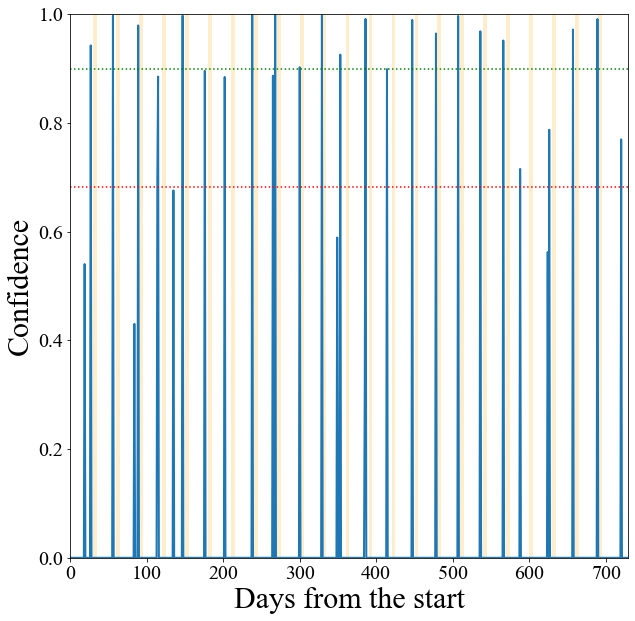

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(1-harmonic_pvals,lw=2)
ax.set_ylim([0,1])
ax.plot([0.9 for i in range(len(X[0]))],":",color="green")
ax.plot([chi2.cdf(1,df=1) for i in range(len(X[0]))],":",color="red")
for j in range(len(changepoint_startday)):
    r = patches.Rectangle(xy=(changepoint_startday[j], 0), width=(changepoint_endday[j]-changepoint_startday[j]), 
                          height=(1), ec=None , fill=True,color="orange",alpha=0.2)
    ax.add_patch(r)
ax.set_yticks([0.2*i for i in range(6)])
ax.set_yticklabels([np.round(0.2*i,2) for i in range(6)],fontsize=20)
ax.set_xticks([100*i for i in range(8)])
ax.set_xticklabels([100*i for i in range(8)],fontsize=20)
ax.set_xlabel("Days from the start",fontsize=30)
ax.set_ylabel("Confidence",fontsize=30)